## Imports and Data Loading

### Imports

In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold, cross_val_predict
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import confusion_matrix, mean_squared_error
import seaborn as sns
from IPython.display import display, HTML
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE  # Recursive Feature Elimination for feature selection
from catboost import CatBoostClassifier
from sklearn.preprocessing import MinMaxScaler
from matplotlib.ticker import ScalarFormatter
from sklearn.neural_network import MLPClassifier

### Loading 2013-2014 NHANES Data

In [173]:
# Read the CSV files into dfs
df1 = pd.read_csv('questionnaire.csv')
df2 = pd.read_csv('demographic.csv')
df3 = pd.read_csv('diet.csv')
df4 = pd.read_csv('examination.csv')

### Loading 2015-2016

In [174]:
df15_16 = pd.read_csv('merged_data.csv')
# Set numbers between 0 and 0.0001 to 0
df15_16 = df15_16.applymap(lambda x: 0 if isinstance(x, (int, float)) and 0 < x < 0.0001 else x)

C:\Users\samco\AppData\Local\Temp\ipykernel_12296\4020531852.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df15_16 = df15_16.applymap(lambda x: 0 if isinstance(x, (int, float)) and 0 < x < 0.0001 else x)


### Loading 2011-12 

To be used as an external test in this method so far

In [175]:
df_11_12 = pd.read_csv('merged_2011_2012.csv')

df_11_12 = df_11_12.applymap(lambda x: 0 if isinstance(x, (int, float)) and 0 < x < 0.0001 else x)

C:\Users\samco\AppData\Local\Temp\ipykernel_12296\3453741107.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_11_12 = df_11_12.applymap(lambda x: 0 if isinstance(x, (int, float)) and 0 < x < 0.0001 else x)


### Merging Data into single DF

In [176]:
# Merge the dfs on the 'seqn' column
df = df1.merge(df2, on='SEQN').merge(df3, on='SEQN').merge(df4, on='SEQN')

print(df.shape)

df = pd.concat([df, df15_16], ignore_index=True)
# df = pd.concat([df, df_11_12], ignore_index=True)

# Print the merged df
print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)
print(df.shape)


(9813, 1389)
(10175, 953)
(10175, 47)
(9813, 168)
(9813, 224)
(19784, 1410)


### Choosing columns

In [177]:
# List of columns to keep
columns_to_keep = [
    'SEQN', 'RIAGENDR', 'RIDAGEYR', 'DMDEDUC2', 'BPXDI1', 'BPXDI2', 'BPXDI3', 'BPXSY1', 'BPXSY2', 'BPXSY3', 'BMXBMI', 'BMXHT', 'BMXWAIST', 'BMXWT', 'BPQ080',
    'DRQSPREP', 'DIQ010','PAQ650', 'PAQ665', 'ALQ101','ALQ151', 'ALQ120Q', 'ALQ120U', 'ALQ130', 'SMQ020', 'SMQ040', 'DBQ700', 'HSD010', 'SMQ050Q', 'SMQ050U', 'SMD055', 'SMD057', 'SMD641', 'SMD650', 'SMD030'
]

# Drop all columns except for the specified ones
df = df[columns_to_keep]

df_11_12 = df_11_12[columns_to_keep]

# Drop all rows where RIDAGEYR is less than 18
df = df[df['RIDAGEYR'] >= 18]

df_11_12 = df_11_12[df_11_12['RIDAGEYR'] >= 18]

df.head()

,SEQN,RIAGENDR,RIDAGEYR,DMDEDUC2,BPXDI1,BPXDI2,BPXDI3,BPXSY1,BPXSY2,BPXSY3,...,SMQ040,DBQ700,HSD010,SMQ050Q,SMQ050U,SMD055,SMD057,SMD641,SMD650,SMD030
0,73557.0,1.0,69.0,3.0,72.0,76.0,74.0,122.0,114.0,102.0,...,3.0,2.0,2.0,3.0,4.0,66.0,2.0,NaN,NaN,17.0
1,73558.0,1.0,54.0,3.0,62.0,80.0,42.0,156.0,160.0,156.0,...,2.0,3.0,4.0,NaN,NaN,NaN,NaN,1.0,1.0,0.0
2,73559.0,1.0,72.0,4.0,90.0,76.0,80.0,140.0,140.0,146.0,...,3.0,3.0,3.0,40.0,4.0,26.0,3.0,NaN,NaN,20.0
4,73561.0,2.0,73.0,5.0,86.0,88.0,86.0,136.0,134.0,142.0,...,NaN,2.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,73562.0,1.0,56.0,4.0,84.0,82.0,80.0,160.0,158.0,154.0,...,3.0,5.0,5.0,16.0,4.0,40.0,5.0,NaN,NaN,18.0


### Filling nulls that can be imputed

In [178]:
# Filling Nulls Due to Skip Questions
df.loc[df['ALQ101'] == 2, ['ALQ120U', 'ALQ120Q', 'ALQ130']] = df.loc[df['ALQ101'] == 2, ['ALQ120U', 'ALQ120Q', 'ALQ130']].fillna(0)
df.loc[df['ALQ101'] == 2, ['ALQ151']] = df.loc[df['ALQ101'] == 2, ['ALQ151']].fillna(2)
df.loc[df['ALQ120Q'] == 0, ['ALQ130']] = df.loc[df['ALQ120Q'] == 0, ['ALQ130']].fillna(0)

df.loc[df['SMQ020'] != 1, ['SMQ040']] = df.loc[df['SMQ020'] != 1, ['SMQ040']].fillna(3)

df.loc[df['ALQ120Q'] <= 3, ['ALQ130']] = df.loc[df['ALQ120Q'] <= 3, ['ALQ130']].fillna(0)

# Filling Nulls Due to Skip Questions
df_11_12.loc[df_11_12['ALQ101'] == 2, ['ALQ120U', 'ALQ120Q', 'ALQ130']] = df_11_12.loc[df_11_12['ALQ101'] == 2, ['ALQ120U', 'ALQ120Q', 'ALQ130']].fillna(0)
df_11_12.loc[df_11_12['ALQ101'] == 2, ['ALQ151']] = df_11_12.loc[df_11_12['ALQ101'] == 2, ['ALQ151']].fillna(2)
df_11_12.loc[df_11_12['ALQ120Q'] == 0, ['ALQ130']] = df_11_12.loc[df_11_12['ALQ120Q'] == 0, ['ALQ130']].fillna(0)

df_11_12.loc[df_11_12['SMQ020'] != 1, ['SMQ040']] = df_11_12.loc[df_11_12['SMQ020'] != 1, ['SMQ040']].fillna(3)

df_11_12.loc[df_11_12['ALQ120Q'] <= 3, ['ALQ130']] = df_11_12.loc[df_11_12['ALQ120Q'] <= 3, ['ALQ130']].fillna(0)

### Improving Column Names

In [179]:
# Rename the columns as specified
new_column_names = {
    'SEQN': 'ID',
    'RIAGENDR': 'Gender',
    'RIDAGEYR': 'Age',
    'BPXDI1': 'DiasBP1',
    'BPXDI2': 'DiasBP2',
    'BPXDI3': 'DiasBP3',
    'BPXSY1': 'SysBP1',
    'BPXSY2': 'SysBP2',
    'BPXSY3': 'SysBP3',
    'BMXBMI': 'BMI',
    'BMXHT': 'Height',
    'BMXWAIST': 'Waist',
    'BMXWT': 'Weight',
    'BPQ080': 'Cholesterol',
    'DRQSPREP': 'SaltFreq',
    'PAQ650': 'VigActivity',
    'PAQ665': 'ModActivity',
    'ALQ151': 'AlcConsumpMoreThan4/5MostDays',
    'ALQ120Q': 'AlcConsumpFreq',
    'ALQ120U' : 'UnitAlc',
    'ALQ130': 'AlcConsumpAmtPerDrinkDay',
    'SMQ020': '100Cigs',
    'DBQ700': 'OvrDietHealth',
    'HSD010': 'GenHealth',
    'SMQ040': 'Smoker',
    'DMDEDUC2': 'EducationLvl',
    'DIQ010' : 'Diabetes',
    'SMD030' : 'AgeStartedSmokingReg',
    'SMQ050Q': 'TimeQuit',
    'SMD055': 'AgeLastSmokedReg',
    'SMD057': 'WhenSmokedCigs/Day',
    'SMD641': 'DaysSmokedInLast30',
    'SMD650': 'AvgCigs/DayInLast30'
}

df.rename(columns=new_column_names, inplace=True)

df_11_12.rename(columns=new_column_names, inplace=True)


## Feature Descriptions

### Cholesterol
- **Question:** Do you suffer from high cholesterol?

### Diet
- **Question:** Are you on a diet?

### Salt Frequency
- **Question:** How often do you add salt to your food?
  - 1 = Never
  - 2 = Rarely
  - 3 = Occasionally
  - 4 = Very Often

### Asthma
- **Question:** Have you ever been told you have asthma? (Refer to MCQ035 to check if you still have it)

### Stroke
- **Question:** Have you ever had a stroke?

### Vigorous Activity
- **Question:** Do you engage in any vigorous activity?

### Moderate Activity
- **Question:** Do you engage in any moderate activity?

### Over the Last 2 Weeks...
- **FeelPoorEating:** Have you been bothered by poor eating or appetite?
- **FeelTired:** Have you felt tired?
- **SleepTroubles:** Have you struggled to fall asleep, stay asleep, or slept too much?
- **FeelDepressed:** Have you felt depressed?

### Alcohol Consumption
- **AlcConsumpMoreThan4/5MostDays:** Have you ever consumed more than 4/5 drinks on most days?
- **AlcConsumpFreq:** How many days have you consumed alcohol in the past year?
- **AlcConsumpAmtPerDrinkDay:** On days you drank in the last year, on average, how many drinks did you have?

### Smoking
- **SMD030:** Age started smoking regularly (skip if < 100 cigs)
  - 7-64
  - 0 = Never regular
  - 80 = 80+
- **Smoker:** Do you currently smoke?
  - 1 = Every day
  - 2 = Some days
  - 3 = Never
- **SMQ050Q:** How long since you quit? (Skip if smoker = 1/2)
- **SMD055:** Age last smoked regularly (skip if still smokes/< 100 cigs)
- **SMD057:** When did you smoke, how many? (Skip if still smokes/< 100 cigs)
  - 1-90
  - 95+
- **SMD641:** Days smoked in the past 30 days (skip if not a current smoker)
- **SMD650:** Average number of cigarettes per day in the past 30 days (skip if not a current smoker)

### Overall Diet Health
- **Question:** How would you rate the health of your diet?
  - 1 = Excellent
  - 2 = Very good
  - 3 = Good
  - 4 = Fair
  - 5 = Poor

### General Health
- **Question:** How would you rate your general health condition?
  - 1 = Excellent
  - 2 = Very good
  - 3 = Good
  - 4 = Fair
  - 5 = Poor

### Sleep During Work Days
- **Question:** How much sleep do you get during work days?
  - 2-11 hours
  - 12 = 12+ hours

### Education Level
- **Question:** What is the highest level of school that you have completed?
  - 1 = Less than grade 9
  - 2 = Less than matriculated
  - 3 = High school graduate
  - 4 = Some college degree
  - 5 = College graduate or higher

### Diabetes
- **Question:** Has a doctor ever told you that you have diabetes?
  - 1 = Yes
  - 2 = No
  - 3 = Borderline

### Prediabetic
- **Question:** Has a doctor ever told you that you are prediabetic?


# Data Exploration

In [180]:
df.isnull().sum()

ID                                  0
Gender                              0
Age                                 0
EducationLvl                      609
DiasBP1                          1089
DiasBP2                           762
DiasBP3                           787
SysBP1                           1089
SysBP2                            762
SysBP3                            787
BMI                               407
Height                            386
Waist                             961
Weight                            390
Cholesterol                         0
SaltFreq                         1211
Diabetes                            0
VigActivity                         0
ModActivity                         0
ALQ101                           1287
AlcConsumpMoreThan4/5MostDays    1292
AlcConsumpFreq                   1289
UnitAlc                          2335
AlcConsumpAmtPerDrinkDay         1289
100Cigs                             0
Smoker                              0
OvrDietHealt

In [181]:
def plot_bivariate(col, hue):
    if df[col].nunique() > 5:
        plt.figure(figsize=(20, 10))
        rot = 90
    else:
        plt.figure(figsize=(10, 7))
        rot = 0

    def percentage(ax):
        heights = [[p.get_height() for p in bars] for bars in ax.containers]  # Get the counts of each bar, make arrays when more than one in group
        min_length = min(len(group) for group in heights)  # Find the minimum length of the groups
        for bars in ax.containers:
            for i, p in enumerate(bars):
                if i >= min_length:
                    continue  # Skip if index is out of range for any group
                total = sum(group[i] for group in heights)  # Sum total of each group
                percentage = (100 * p.get_height() / total)  # Calculate % to annotate
                ax.annotate(format(p.get_height()), (p.get_x() + p.get_width() * 0.5, 0.8 * p.get_height()), 
                            ha='center', va='bottom', rotation=0)
                if percentage > 25.0:
                    percentage = f'{percentage:.1f}%'
                    ax.annotate(percentage, (p.get_x() + p.get_width() * 0.5, 0.25 * p.get_height()), 
                                ha='center', va='center', rotation=rot)

    plot = sns.countplot(x=df[col], hue=df[hue], palette='pastel')
    percentage(plot)
    plt.xticks(rotation=rot)
    plt.show()

In [182]:
def calculate_average(df, features, new_feature_name):
    # Check and select the relevant columns from the df
    relevant_columns = df[features].replace({0: np.nan})  # Replace zeros with NaN to exclude from mean calculation
    
    # Calculate the mean across the specified columns, ignoring NaN values
    df[new_feature_name] = relevant_columns.mean(axis=1, skipna=True)

## Creating BP features

In [183]:
diasBP_features = ['DiasBP1', 'DiasBP2', 'DiasBP3']
sysBP_features = ['SysBP1', 'SysBP2', 'SysBP3']

calculate_average(df, diasBP_features, 'AvgDiasBP')
calculate_average(df, sysBP_features, 'AvgSysBP')

calculate_average(df_11_12, diasBP_features, 'AvgDiasBP')
calculate_average(df_11_12, sysBP_features, 'AvgSysBP')

In [184]:
# Drop rows where AvgSysBP is null
df = df.dropna(subset=['AvgSysBP'])
df_11_12 = df_11_12.dropna(subset=['AvgSysBP'])

## Creating a Hypertension Variable

In [185]:
conditions = [
    df['AvgSysBP'] < 130,
    (df['AvgSysBP'] >= 130)
]
values = [0, 1]

# Use np.select to handle NaNs and assign the appropriate category
df['HypertensionLvl'] = np.select(conditions, values, default=np.nan)

conditions_df_11_12 = [
    df_11_12['AvgSysBP'] < 130,
    df_11_12['AvgSysBP'] >= 130
]
df_11_12['HypertensionLvl'] = np.select(conditions_df_11_12, values, default=np.nan)

## Creating Smoking Features

In [186]:
df.loc[df['TimeQuit'] == 66666, 'TimeQuit'] = 50
df_11_12.loc[df_11_12['TimeQuit'] == 66666, 'TimeQuit'] = 50

In [187]:
# Define the transformation function
def transform_time_quit(row):
    if row['SMQ050U'] == 1:
        return 0
    elif row['SMQ050U'] == 2:
        return (row['TimeQuit'] / 52)
    elif row['SMQ050U'] == 3:
        return (row['TimeQuit'] / 12)
    else:
        return row['TimeQuit']

# Apply the transformation to the TimeQuit column
df['TimeQuit'] = df.apply(transform_time_quit, axis=1)
df_11_12['TimeQuit'] = df_11_12.apply(transform_time_quit, axis=1)

In [188]:
# Update AgeLastSmokedReg where it is null, TimeQuit is not null, and TimeQuit is smaller than 100
df.loc[(df['AgeLastSmokedReg'].isnull()) & (df['TimeQuit'].notnull()) & (df['TimeQuit'] < 100) & (df['Smoker'] == 3) & (df['100Cigs'] == 1), 'AgeLastSmokedReg'] = df['Age'] - df['TimeQuit']
df_11_12.loc[(df_11_12['AgeLastSmokedReg'].isnull()) & (df_11_12['TimeQuit'].notnull()) & (df_11_12['TimeQuit'] < 100) & (df_11_12['Smoker'] == 3) & (df_11_12['100Cigs'] == 1), 'AgeLastSmokedReg'] = df_11_12['Age'] - df_11_12['TimeQuit']

### Creating YearsSmoked Feature

In [189]:
df.loc[df['AgeStartedSmokingReg'] > 100, 'AgeStartedSmokingReg'] = np.nan
df_11_12.loc[df_11_12['AgeStartedSmokingReg'] > 100, 'AgeStartedSmokingReg'] = np.nan
df.loc[df['TimeQuit'] > 66666, 'TimeQuit'] = np.nan
df_11_12.loc[df_11_12['TimeQuit'] > 66666, 'TimeQuit'] = np.nan
df.loc[df['AgeLastSmokedReg'] > 100, 'AgeLastSmokedReg'] = np.nan
df_11_12.loc[df_11_12['AgeLastSmokedReg'] > 100, 'AgeLastSmokedReg'] = np.nan
df = df.drop(columns=['SMQ050U'])
df_11_12 = df_11_12.drop(columns=['SMQ050U'])

df['yearsSmoked'] = np.where(
    df['Smoker'].isin([1, 2]),
    df['Age'] - df['AgeStartedSmokingReg'],
    df['AgeLastSmokedReg'] - df['AgeStartedSmokingReg']
)
df_11_12['yearsSmoked'] = np.where(
    df_11_12['Smoker'].isin([1, 2]),
    df_11_12['Age'] - df_11_12['AgeStartedSmokingReg'],
    df_11_12['AgeLastSmokedReg'] - df_11_12['AgeStartedSmokingReg']
)

df['yearsSmoked'] = df['yearsSmoked'].fillna(0)
df_11_12['yearsSmoked'] = df_11_12['yearsSmoked'].fillna(0)

C:\Users\samco\AppData\Local\Temp\ipykernel_12296\3170566072.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  hypertension_percentage = df.groupby('yearsSmokedBinned')['HypertensionLvl'].value_counts(normalize=True).unstack().fillna(0) * 100


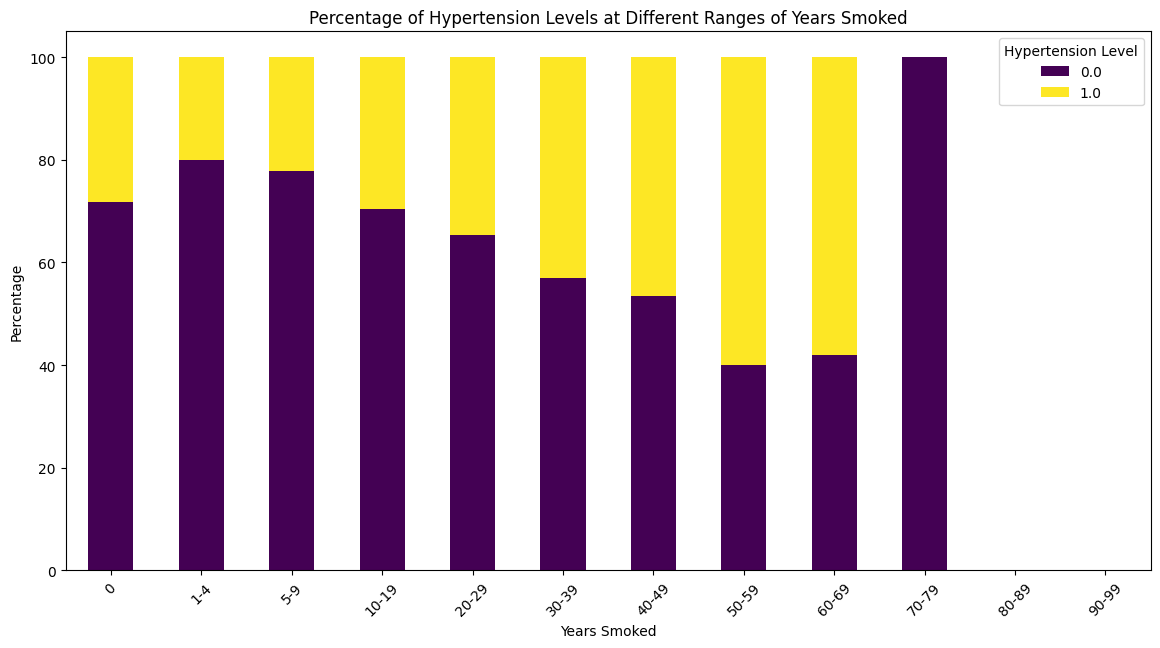

In [190]:
# Bin the yearsSmoked values
bins = [0, 1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0', '1-4', '5-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99']
df['yearsSmokedBinned'] = pd.cut(df['yearsSmoked'], bins=bins, labels=labels, right=False)

# Calculate the percentage of hypertension levels for each bin of yearsSmoked
hypertension_percentage = df.groupby('yearsSmokedBinned')['HypertensionLvl'].value_counts(normalize=True).unstack().fillna(0) * 100

# Plot the data
plt.figure(figsize=(14, 7))
hypertension_percentage.plot(kind='bar', stacked=True, colormap='viridis', ax=plt.gca())
plt.title('Percentage of Hypertension Levels at Different Ranges of Years Smoked')
plt.xlabel('Years Smoked')
plt.ylabel('Percentage')
plt.legend(title='Hypertension Level')
plt.xticks(rotation=45)
plt.show()

### Creating LifetimeCigarettes Feature

In [191]:
# Define the transformation function
def calculate_lifetime_cigarettes(row):
    if row['Smoker'] == 3:
        if pd.isnull(row['WhenSmokedCigs/Day']) | (row['WhenSmokedCigs/Day'] > 100):
            return 0
        return row['yearsSmoked'] * row['WhenSmokedCigs/Day'] * 365
    elif row['Smoker'] in [1, 2]:
        if pd.isnull(row['AvgCigs/DayInLast30']) | (row['AvgCigs/DayInLast30'] > 100):
            return 0
        return row['yearsSmoked'] * row['AvgCigs/DayInLast30'] * row['DaysSmokedInLast30'] /30 * 365
    else:
        return np.nan

# Apply the transformation to create the lifetimeCigarettes feature
df['lifetimeCigarettes'] = df.apply(calculate_lifetime_cigarettes, axis=1)
df_11_12['lifetimeCigarettes'] = df_11_12.apply(calculate_lifetime_cigarettes, axis=1)

# Verify the changes
print(df[['Smoker', 'yearsSmoked', 'WhenSmokedCigs/Day', 'AvgCigs/DayInLast30', 'DaysSmokedInLast30', 'lifetimeCigarettes']].head(20))

    Smoker  yearsSmoked  WhenSmokedCigs/Day  AvgCigs/DayInLast30  \
0      3.0    49.000000                 2.0                  NaN   
1      2.0    54.000000                 NaN                  1.0   
2      3.0     6.000000                 3.0                  NaN   
4      3.0     0.000000                 NaN                  NaN   
5      3.0    22.000000                 5.0                  NaN   
7      3.0     0.000000                 NaN                  NaN   
8      1.0    23.000000                 NaN                  1.0   
9      1.0    44.000000                 NaN                 25.0   
10     3.0     0.000000                 NaN                  NaN   
12     3.0     0.000000                 NaN                  NaN   
15     3.0     0.000000                 NaN                  NaN   
18     3.0    21.333333                20.0                  NaN   
19     3.0     0.000000                 NaN                  NaN   
21     3.0     0.000000                 NaN     

C:\Users\samco\AppData\Local\Temp\ipykernel_12296\2307530192.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  hypertension_percentage = df.groupby('lifetimeCigarettesBinned')['HypertensionLvl'].value_counts(normalize=True).unstack().fillna(0) * 100


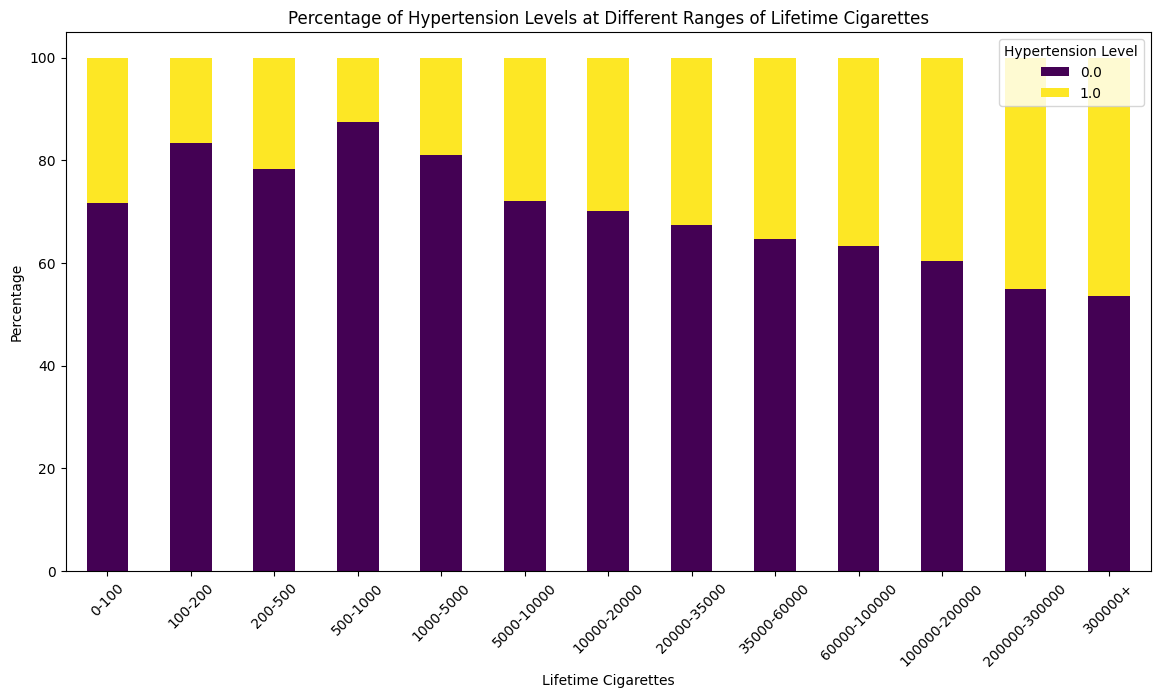

In [192]:
# Bin the lifetimeCigarettes values
bins = [0, 100, 200, 500, 1000, 5000, 10000, 20000, 35000, 60000, 100000, 200000, 300000, 1000000000000]
labels = ['0-100', '100-200', '200-500', '500-1000', '1000-5000', '5000-10000', '10000-20000', '20000-35000', '35000-60000', '60000-100000', '100000-200000', '200000-300000', '300000+']
df['lifetimeCigarettesBinned'] = pd.cut(df['lifetimeCigarettes'], bins=bins, labels=labels, right=False)

# Calculate the percentage of hypertension levels for each bin of lifetimeCigarettes
hypertension_percentage = df.groupby('lifetimeCigarettesBinned')['HypertensionLvl'].value_counts(normalize=True).unstack().fillna(0) * 100

# Plot the data
plt.figure(figsize=(14, 7))
hypertension_percentage.plot(kind='bar', stacked=True, colormap='viridis', ax=plt.gca())
plt.title('Percentage of Hypertension Levels at Different Ranges of Lifetime Cigarettes')
plt.xlabel('Lifetime Cigarettes')
plt.ylabel('Percentage')
plt.legend(title='Hypertension Level')
plt.xticks(rotation=45)
plt.show()

## Alcohol Features

In [193]:
def transform_alc_consump_freq(row):
    if row['UnitAlc'] == 1:
        return (row['AlcConsumpFreq'] * 52)
    elif row['UnitAlc'] == 2:
        return (row['AlcConsumpFreq'] * 12)
    else:
        if (row['AlcConsumpFreq'] > 365):
            return np.nan
        return row['AlcConsumpFreq']
    

df['AlcConsumpFreq'] = df.apply(transform_alc_consump_freq, axis=1)
df_11_12['AlcConsumpFreq'] = df_11_12.apply(transform_alc_consump_freq, axis=1)

In [194]:
# Set values in 'AlcConsumpAmtPerDrinkDay' to NaN where the condition is met
df.loc[df['AlcConsumpAmtPerDrinkDay'] > 25, 'AlcConsumpAmtPerDrinkDay'] = np.nan
df_11_12.loc[df_11_12['AlcConsumpAmtPerDrinkDay'] > 25, 'AlcConsumpAmtPerDrinkDay'] = np.nan

# Calculate the new column 'AlcConsump/Yr' by multiplying the relevant columns
df['AlcConsump/Yr'] = df['AlcConsumpAmtPerDrinkDay'] * df['AlcConsumpFreq']
df_11_12['AlcConsump/Yr'] = df_11_12['AlcConsumpAmtPerDrinkDay'] * df_11_12['AlcConsumpFreq']

## Activity Level Features

In [195]:
#Combine vig and mod activity

df['ActivityLvl'] = df.apply(
    lambda row: 1 if row['VigActivity'] == 1 
    else (0.5 if row['VigActivity'] != 1 and row['ModActivity'] == 1 else 0), axis=1
)
df_11_12['ActivityLvl'] = df_11_12.apply(
    lambda row: 1 if row['VigActivity'] == 1 
    else (0.5 if row['VigActivity'] != 1 and row['ModActivity'] == 1 else 0), axis=1
)

df['WeightedActivity'] = df.apply(
    lambda row: (row['VigActivity'] * 2 if row['VigActivity'] == 1 else 0) + 
                (row['ModActivity'] if row['ModActivity'] == 1 else 0), axis=1
)

df_11_12['WeightedActivity'] = df_11_12.apply(
    lambda row: (row['VigActivity'] * 2 if row['VigActivity'] == 1 else 0) + 
                (row['ModActivity'] if row['ModActivity'] == 1 else 0), axis=1
)

In [196]:
df = df.dropna(thresh=len(df) - 5000, axis=1)
df_11_12 = df_11_12.dropna(thresh=len(df_11_12) - 2000, axis=1)
df.isnull().sum()

ID                                  0
Gender                              0
Age                                 0
EducationLvl                      580
DiasBP1                           456
DiasBP2                           129
DiasBP3                           154
SysBP1                            456
SysBP2                            129
SysBP3                            154
BMI                               118
Height                             99
Waist                             575
Weight                            102
Cholesterol                         0
SaltFreq                          788
Diabetes                            0
VigActivity                         0
ModActivity                         0
ALQ101                            879
AlcConsumpMoreThan4/5MostDays     884
AlcConsumpFreq                    888
UnitAlc                          1900
AlcConsumpAmtPerDrinkDay          887
100Cigs                             0
Smoker                              0
OvrDietHealt

## Dropping unused features

In [197]:
df = df.drop(columns=['ID', 'DiasBP1', 'DiasBP2', 'DiasBP3', 'SysBP1', 
                      'SysBP2', 'SysBP3', 'AvgDiasBP', 'ALQ101', 'AlcConsumpMoreThan4/5MostDays', 
                      'UnitAlc', 'AlcConsumpAmtPerDrinkDay', '100Cigs', 'yearsSmokedBinned', 'lifetimeCigarettesBinned'])
df_11_12 = df_11_12.drop(columns=['ID', 'DiasBP1', 'DiasBP2', 'DiasBP3', 'SysBP1',
                                  'SysBP2', 'SysBP3', 'AvgDiasBP', 'ALQ101', 'AlcConsumpMoreThan4/5MostDays',
                                  'UnitAlc', 'AlcConsumpAmtPerDrinkDay', '100Cigs'])
null_values = df.isnull().sum()

In [198]:
df = df.dropna()
df_11_12 = df_11_12.dropna()

### Removing rows from training that go against the desired trends

In [199]:
# Define the conditions
conditions = (
    (df['Age'] < 45) &
    (df['BMI'] < 26) &
    (df['Waist'] < 130) &
    (df['yearsSmoked'] < 2) &
    (df['WeightedActivity'] > 0) &
    (df['HypertensionLvl'] > 0) &
    (df['AlcConsump/Yr'] < 200)
)

# Filter the DataFrame based on the conditions
filtered_df = df[conditions]

# Drop all rows that meet the conditions
df.drop(df[conditions].index, inplace=True)

In [200]:
conditions = (
    (df['Age'] > 55) &
    (df['BMI'] > 30) &
    (df['yearsSmoked'] > 10) &
    (df['WeightedActivity'] < 1) &
    (df['HypertensionLvl'] == 0) 
)
filtered_df = df[conditions]
df.drop(df[conditions].index, inplace=True)

In [201]:
conditions = (
    (df['Age'] > 55) &
    (df['BMI'] > 30) &
    (df['AlcConsump/Yr'] > 200) &
    (df['WeightedActivity'] < 1) &
    (df['HypertensionLvl'] == 0) 
)
filtered_df = df[conditions]
df.drop(df[conditions].index, inplace=True)

In [202]:
for column in df.columns:
    print(f"Maximum value for {column}: {df[column].max()}")

Maximum value for Gender: 2.0
Maximum value for Age: 80.0
Maximum value for EducationLvl: 9.0
Maximum value for BMI: 70.1
Maximum value for Height: 202.7
Maximum value for Waist: 172.5
Maximum value for Weight: 198.9
Maximum value for Cholesterol: 9.0
Maximum value for SaltFreq: 9.0
Maximum value for Diabetes: 9.0
Maximum value for VigActivity: 9.0
Maximum value for ModActivity: 9.0
Maximum value for AlcConsumpFreq: 365.0
Maximum value for Smoker: 3.0
Maximum value for OvrDietHealth: 9.0
Maximum value for GenHealth: 5.0
Maximum value for AvgSysBP: 231.33333333333334
Maximum value for HypertensionLvl: 1.0
Maximum value for yearsSmoked: 71.0
Maximum value for lifetimeCigarettes: 1664400.0
Maximum value for AlcConsump/Yr: 6552.0
Maximum value for ActivityLvl: 1.0
Maximum value for WeightedActivity: 3.0


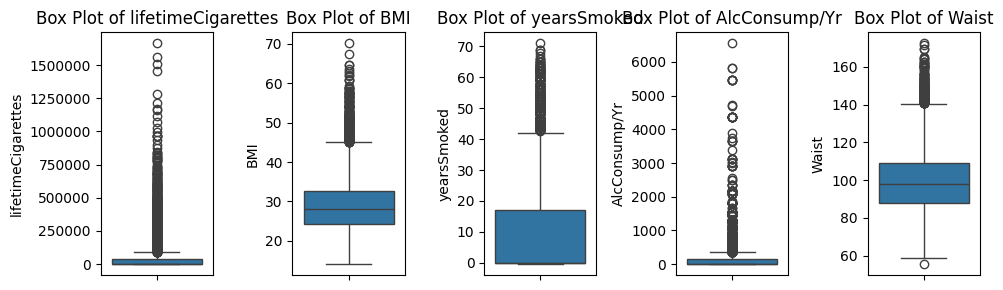

In [203]:
# Create a figure and axis
fig, ax = plt.subplots(1, 5, figsize=(10, 3))

# Create a box plot for Age
sns.boxplot(y=df['lifetimeCigarettes'], ax=ax[0])
ax[0].set_title('Box Plot of lifetimeCigarettes')

ax[0].yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
ax[0].ticklabel_format(style='plain', axis='y')

# Create a box plot for BMI
sns.boxplot(y=df['BMI'], ax=ax[1])
ax[1].set_title('Box Plot of BMI')

sns.boxplot(y=df['yearsSmoked'], ax=ax[2])
ax[2].set_title('Box Plot of yearsSmoked')

sns.boxplot(y=df['AlcConsump/Yr'], ax=ax[3])
ax[3].set_title('Box Plot of AlcConsump/Yr')

sns.boxplot(y=df['Waist'], ax=ax[4])
ax[4].set_title('Box Plot of Waist')

# Display the plots
plt.tight_layout()
plt.show()

### Setting outlier values to a value that maintain the relationship but will not negatively affect models

In [204]:
# Cap lifetimeCigarettes at 400,000
df.loc[df['lifetimeCigarettes'] > 400000, 'lifetimeCigarettes'] = 400000
df_11_12.loc[df_11_12['lifetimeCigarettes'] > 400000, 'lifetimeCigarettes'] = 400000

# Cap BMI at 45
df.loc[df['BMI'] > 45, 'BMI'] = 45
df_11_12.loc[df_11_12['BMI'] > 45, 'BMI'] = 45

# Cap yearsSmoked at 45
df.loc[df['yearsSmoked'] > 45, 'yearsSmoked'] = 45
df_11_12.loc[df_11_12['yearsSmoked'] > 45, 'yearsSmoked'] = 45

# Cap AlcConsump/Yr at 900
df.loc[df['AlcConsump/Yr'] > 900, 'AlcConsump/Yr'] = 900
df_11_12.loc[df_11_12['AlcConsump/Yr'] > 900, 'AlcConsump/Yr'] = 900

# Cap waist at 150 and set minimum waist to 60
df.loc[df['Waist'] > 150, 'Waist'] = 150
df_11_12.loc[df_11_12['Waist'] > 150, 'Waist'] = 150
df.loc[df['Waist'] < 60, 'Waist'] = 60
df_11_12.loc[df_11_12['Waist'] < 60, 'Waist'] = 60

### Fixing any refused-to-answer fields

In [205]:
# Set Cholesterol, SaltFreq, Diabetes, OvrDietHealth to their mode when they equal 9
for column in ['Cholesterol', 'SaltFreq', 'Diabetes', 'OvrDietHealth', 'EducationLvl']:
    if not df[column].dropna().empty:  # Check if column is not entirely NaN or empty
        mode_value = df[column].mode()
        if not mode_value.empty:  # Check if mode calculation returned a value
            mode_value = mode_value[0]
            df.loc[(df[column] == 9) | (df[column] == 7), column] = mode_value
        else:
            print(f"No mode found for {column}.")
    else:
        print(f"Column {column} is empty or has only NaN values.")

for column in ['Cholesterol', 'SaltFreq', 'Diabetes', 'OvrDietHealth', 'EducationLvl']:
    if not df_11_12[column].dropna().empty:  # Check if column is not entirely NaN or empty
        mode_value = df_11_12[column].mode()
        if not mode_value.empty:  # Check if mode calculation returned a value
            mode_value = mode_value[0]
            df_11_12.loc[(df[column] == 9) | (df_11_12[column] == 7), column] = mode_value
        else:
            print(f"No mode found for {column}.")
    else:
        print(f"Column {column} is empty or has only NaN values.")


# Set YearsSmoked and LifetimeCigarettes to 0 if they are less than 0
df.loc[df['yearsSmoked'] < 0, 'yearsSmoked'] = 0
df_11_12.loc[df_11_12['yearsSmoked'] < 0, 'yearsSmoked'] = 0
df.loc[df['lifetimeCigarettes'] < 0, 'lifetimeCigarettes'] = 0
df_11_12.loc[df_11_12['lifetimeCigarettes'] < 0, 'lifetimeCigarettes'] = 0

## Encoding

In [206]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the DataFrame
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_scaled_11_12 = pd.DataFrame(scaler.fit_transform(df_11_12), columns=df.columns)

# Print the first few rows of the scaled DataFrame to verify
print(df_scaled.head())

   Gender       Age  EducationLvl       BMI    Height     Waist    Weight  \
0     0.0  0.816667          0.50  0.407767  0.569863  0.444444  0.276110   
1     0.0  0.566667          0.50  0.469256  0.645205  0.528889  0.343337   
2     0.0  0.866667          0.75  0.478964  0.624658  0.546667  0.339736   
3     0.0  0.600000          0.75  0.893204  0.397260  0.701111  0.436375   
4     1.0  0.683333          1.00  0.699029  0.439726  0.564444  0.366747   

   Cholesterol  SaltFreq  Diabetes  ...  Smoker  OvrDietHealth  GenHealth  \
0          0.0  1.000000       0.0  ...     1.0           0.25       0.25   
1          0.0  0.666667       0.0  ...     0.5           0.50       0.75   
2          0.0  0.333333       0.0  ...     1.0           0.50       0.50   
3          0.0  0.666667       0.5  ...     1.0           1.00       1.00   
4          1.0  0.000000       0.5  ...     1.0           0.75       0.50   

   AvgSysBP  HypertensionLvl  yearsSmoked  lifetimeCigarettes  AlcConsump/

In [207]:
df_scaled = df_scaled.dropna()
df_scaled_11_12 = df_scaled_11_12.dropna()

null_values = df_scaled.isnull().sum()
print("Null values in each column:")

Null values in each column:


In [208]:
# #'AlcConsumpFreq', 'AlcConsumpAmtPerDrinkDay', 'AlcConsump/Yr', 'lifetimeCigarettes'
# df['BMI'] = 1 / (1 + np.exp(-20 * (df['BMI'] - 0.6)))

# df['AlcConsumpFreq'] = 1 / (1 + np.exp(-8 * (df['AlcConsumpFreq'] - 0.5)))

# df['AlcConsump/Yr'] = 1 / (1 + np.exp(-15 * (df['AlcConsump/Yr'] - 0.5)))

# df['lifetimeCigarettes'] = 1 / (1 + np.exp(-15 * (df['lifetimeCigarettes'] - 0.5)))

### Splitting Target

In [209]:
# Create the target variable
target = df_scaled['HypertensionLvl']
target_11_12 = df_scaled_11_12['HypertensionLvl']

# Drop the HypertensionLvl column from the DataFrame
df_scaled = df_scaled.drop(columns=['HypertensionLvl', 'AvgSysBP', 'VigActivity', 'ModActivity', 'BMI', 'ActivityLvl'])
df_scaled_11_12 = df_scaled_11_12.drop(columns=['HypertensionLvl', 'AvgSysBP', 'VigActivity', 'ModActivity', 'BMI', 'ActivityLvl'])

In [210]:
df_scaled.columns

Index(['Gender', 'Age', 'EducationLvl', 'Height', 'Waist', 'Weight',
       'Cholesterol', 'SaltFreq', 'Diabetes', 'AlcConsumpFreq',
       'OvrDietHealth', 'GenHealth', 'yearsSmoked', 'AlcConsump/Yr',
       'WeightedActivity'],
      dtype='object')

### Train-Test-Split

In [211]:
X_train, X_test, Y_train, Y_test = train_test_split(df_scaled, target, test_size=0.35, random_state=42)

# Print the shapes of the resulting splits to verify
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Training target shape:", Y_train.shape)
print("Test target shape:", Y_test.shape)

Training set shape: (5811, 15)
Test set shape: (3130, 15)
Training target shape: (5811,)
Test target shape: (3130,)


## Models

In [212]:
def evaluate_model(model, X_train, X_test, Y_train, Y_test):
    # Train the model
    model.fit(X_train, Y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Check if the model supports predict_proba (required for AUC)
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
    else:
        print("Model does not support probability predictions; AUC cannot be calculated.")
        y_pred_proba = None
    
    # Calculate accuracy
    accuracy = accuracy_score(Y_test, y_pred)
    print(f"Accuracy: {accuracy:.5f}")

    # Create a DataFrame to compare predictions with actual results
    comparison_df = pd.DataFrame({
        'Actual': Y_test,
        'Predicted': y_pred
    })

    # Add predicted probabilities if available
    if y_pred_proba is not None:
        comparison_df['Predicted_Probability'] = y_pred_proba

    # Print the comparison DataFrame
    print("\nComparison DataFrame:")
    print(comparison_df.to_string())

    # Calculate AUC score if probabilities are available
    if y_pred_proba is not None:
        auc = roc_auc_score(Y_test, y_pred_proba)
        print(f"AUC Score: {auc:.5f}")

        # Plot ROC curve
        fpr, tpr, _ = roc_curve(Y_test, y_pred_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'AUC = {auc:.5f}')
        plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')
        plt.show()
    else:
        print("AUC and ROC Curve cannot be plotted as the model does not provide probability estimates.")

## Logistic Regression

Accuracy: 0.73642

Comparison DataFrame:
      Actual  Predicted  Predicted_Probability
6110     0.0        1.0               0.668511
4393     0.0        0.0               0.030054
4002     0.0        0.0               0.355634
8709     0.0        0.0               0.444445
5444     1.0        1.0               0.663741
1330     1.0        0.0               0.311635
6107     1.0        0.0               0.370364
6378     0.0        0.0               0.314321
6929     0.0        0.0               0.421714
6412     0.0        1.0               0.693716
3033     1.0        0.0               0.300606
960      1.0        1.0               0.814232
8770     1.0        1.0               0.694216
315      0.0        0.0               0.205924
7308     1.0        1.0               0.658907
6026     0.0        0.0               0.067048
6768     1.0        1.0               0.554778
1954     0.0        0.0               0.055677
2165     1.0        0.0               0.123428
2142     1.0       

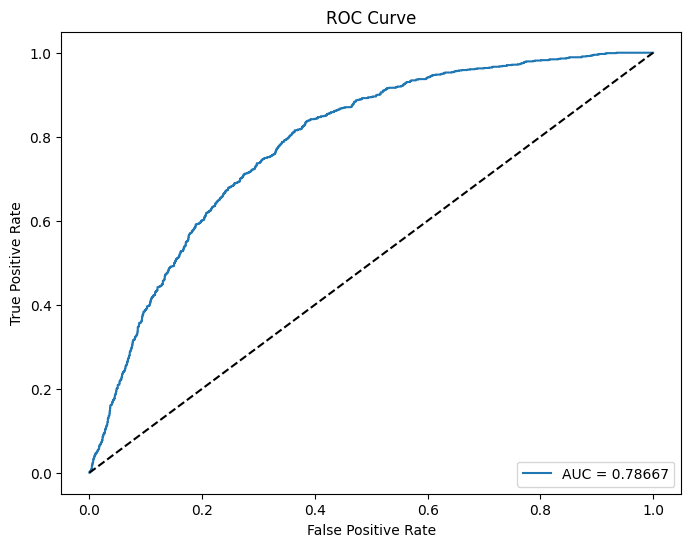

In [213]:
LR_model = LogisticRegression(max_iter=1000)
evaluate_model(LR_model, X_train, X_test, Y_train, Y_test)

## Random Forest

Accuracy: 0.72492

Comparison DataFrame:
      Actual  Predicted  Predicted_Probability
6110     0.0        1.0                   0.54
4393     0.0        0.0                   0.00
4002     0.0        1.0                   0.53
8709     0.0        1.0                   0.60
5444     1.0        1.0                   0.70
1330     1.0        0.0                   0.33
6107     1.0        0.0                   0.41
6378     0.0        0.0                   0.38
6929     0.0        0.0                   0.49
6412     0.0        1.0                   0.72
3033     1.0        0.0                   0.49
960      1.0        1.0                   0.56
8770     1.0        1.0                   0.67
315      0.0        0.0                   0.26
7308     1.0        1.0                   0.68
6026     0.0        0.0                   0.02
6768     1.0        0.0                   0.39
1954     0.0        0.0                   0.02
2165     1.0        0.0                   0.17
2142     1.0       

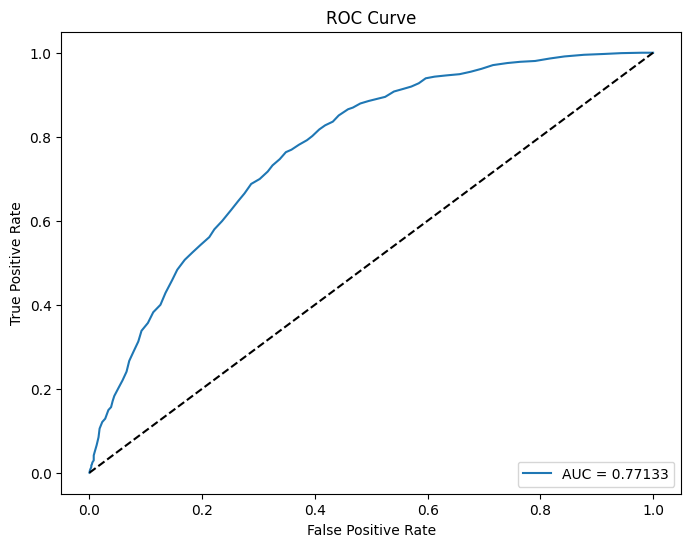

In [214]:
RF_model = RandomForestClassifier(n_estimators=100, random_state=42)
evaluate_model(RF_model, X_train, X_test, Y_train, Y_test)

## Catboost Classifier

Accuracy: 0.73323

Comparison DataFrame:
      Actual  Predicted  Predicted_Probability
6110     0.0        1.0               0.572677
4393     0.0        0.0               0.009711
4002     0.0        0.0               0.470603
8709     0.0        1.0               0.525257
5444     1.0        1.0               0.773995
1330     1.0        0.0               0.288282
6107     1.0        0.0               0.361149
6378     0.0        0.0               0.409260
6929     0.0        0.0               0.369515
6412     0.0        1.0               0.707991
3033     1.0        0.0               0.370350
960      1.0        1.0               0.729420
8770     1.0        1.0               0.647093
315      0.0        0.0               0.215871
7308     1.0        1.0               0.774557
6026     0.0        0.0               0.022231
6768     1.0        1.0               0.520650
1954     0.0        0.0               0.017494
2165     1.0        0.0               0.142812
2142     1.0       

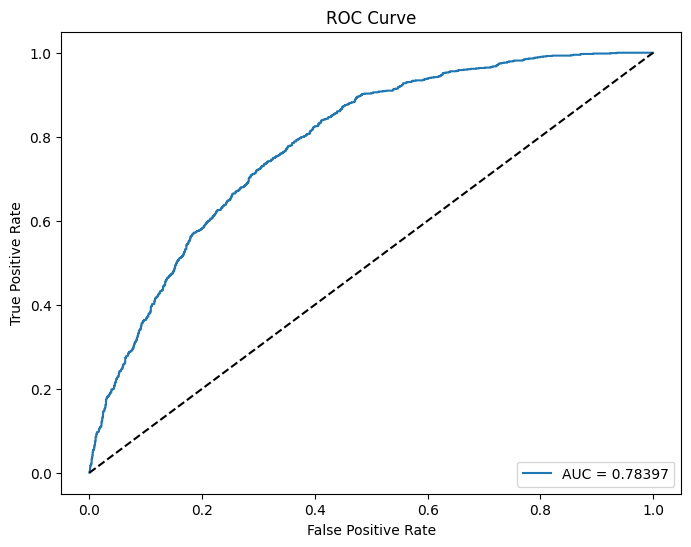

In [215]:
catboost_model = CatBoostClassifier(verbose=0, random_state=42, cat_features=df.select_dtypes(include=['object', 'category']).columns.tolist())
evaluate_model(catboost_model, X_train, X_test, Y_train, Y_test)

## Neural Network 

c:\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.73291

Comparison DataFrame:
      Actual  Predicted  Predicted_Probability
6110     0.0        1.0               0.546365
4393     0.0        0.0               0.015068
4002     0.0        0.0               0.316984
8709     0.0        1.0               0.514952
5444     1.0        1.0               0.632092
1330     1.0        0.0               0.322716
6107     1.0        0.0               0.387270
6378     0.0        0.0               0.358011
6929     0.0        0.0               0.441994
6412     0.0        1.0               0.710244
3033     1.0        0.0               0.304168
960      1.0        1.0               0.690934
8770     1.0        1.0               0.632023
315      0.0        0.0               0.262370
7308     1.0        1.0               0.726340
6026     0.0        0.0               0.027183
6768     1.0        0.0               0.423272
1954     0.0        0.0               0.031285
2165     1.0        0.0               0.160182
2142     1.0       

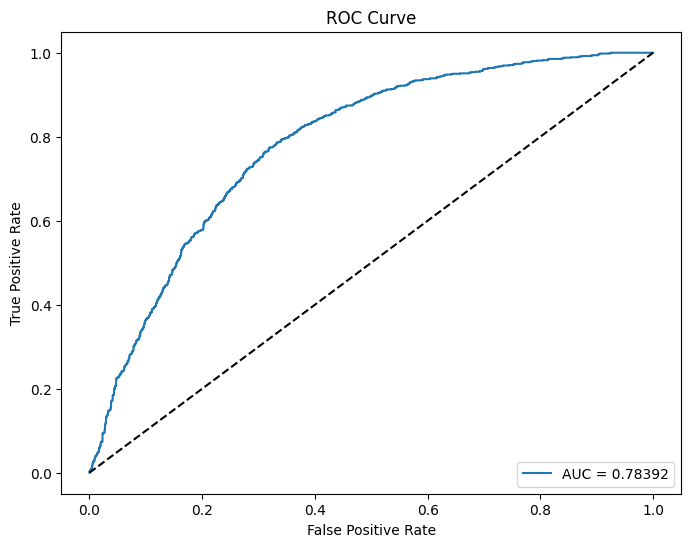

In [216]:
nn_model = MLPClassifier(hidden_layer_sizes=(20,), activation='relu', solver='adam', max_iter=100, random_state=42)
evaluate_model(nn_model, X_train, X_test, Y_train, Y_test)

In [217]:
# # Define the initial neural network model
# nn_model = MLPClassifier(random_state=42)

# # Define a more extensive parameter grid for random search
# param_distributions = {
#     'hidden_layer_sizes': [ (20,), (50,), (100,), (150,), (50, 50), (100, 50), (100, 100),],  # More layer combinations
#     'activation': ['tanh', 'logistic', 'identity'],  # Different activation functions
#     'solver': ['adam', 'sgd'],  # Solvers for weight optimization
#     'alpha': np.logspace(-5, -1, 5),  # L2 penalty (regularization) term
#     'learning_rate': ['constant', 'invscaling', 'adaptive'],  # Learning rate schedules
#     'learning_rate_init': np.logspace(-4, -1, 4),  # Initial learning rate
#     'max_iter': [100, 200, 300],  # Number of epochs
#     'batch_size': [16, 32],  # Size of minibatches
#     'momentum': [0.9, 0.95],  # Momentum for SGD solver
#     'nesterovs_momentum': [True, False],  # Whether to use Nesterov's momentum
#     'early_stopping': [True, False],  # Whether to use early stopping to terminate training
#     'beta_1': [0.8, 0.9],  # Exponential decay rate for estimates of first moment vector in adam
#     'beta_2': [0.9, 0.99],  # Exponential decay rate for estimates of second moment vector in adam
# }

# # Set up the RandomizedSearchCV
# random_search = RandomizedSearchCV(
#     estimator=nn_model,
#     param_distributions=param_distributions,
#     n_iter=70,  # Number of parameter settings sampled
#     scoring='roc_auc',  # Scoring metric to use
#     n_jobs=-1,  # Use all available cores
#     cv=5,  # 5-fold cross-validation
#     verbose=3,  # Verbosity level
#     random_state=42  # Random state for reproducibility
# )

# # Assuming your data is already prepared in X_train and Y_train
# # Perform the random search
# random_search.fit(X_train, Y_train)

# # Print the best parameters and the best score from the random search
# print("Best parameters found by random search:")
# print(random_search.best_params_)

# print("\nBest AUC score from random search:")
# print(f"{random_search.best_score_:.5f}")

# # Optionally, evaluate the best model using your evaluation function
# best_nn_model = random_search.best_estimator_
# evaluate_model(best_nn_model, X_train, X_test, Y_train, Y_test)

### Hyperparameter Tuning for Catboost

In [218]:
# # Initialize CatBoostClassifier
# catboost_model = CatBoostClassifier(verbose=0, random_state=42, cat_features=df.select_dtypes(include=['object', 'category']).columns.tolist())

# # Define the hyperparameter grid
# param_grid = {
#     'iterations': [100, 200, 300],
#     'depth': [4, 6, 8],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'l2_leaf_reg': [1, 3, 5, 7],
#     'border_count': [32, 64, 128]
# }

# # Set up GridSearchCV
# grid_search = GridSearchCV(estimator=catboost_model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# # Fit GridSearchCV
# grid_search.fit(X_train, Y_train)

# # Get the best model from grid search
# best_catboost_model = grid_search.best_estimator_

# # Train the model with the best parameters
# best_catboost_model.fit(X_train, Y_train)

# # Evaluate the best model using the provided evaluate_model function
# evaluate_model(best_catboost_model, X_train, X_test, Y_train, Y_test)

# # Output best parameters
# print("Best parameters found: ", grid_search.best_params_)

Accuracy: 0.73578

Comparison DataFrame:
      Actual  Predicted  Predicted_Probability
6110     0.0        1.0               0.625578
4393     0.0        0.0               0.046591
4002     0.0        0.0               0.438430
8709     0.0        1.0               0.525517
5444     1.0        1.0               0.601644
1330     1.0        0.0               0.367606
6107     1.0        0.0               0.393896
6378     0.0        0.0               0.410321
6929     0.0        1.0               0.500936
6412     0.0        1.0               0.646082
3033     1.0        0.0               0.251372
960      1.0        1.0               0.647956
8770     1.0        1.0               0.615653
315      0.0        0.0               0.180166
7308     1.0        1.0               0.604085
6026     0.0        0.0               0.067115
6768     1.0        1.0               0.541998
1954     0.0        0.0               0.053234
2165     1.0        0.0               0.126628
2142     1.0       

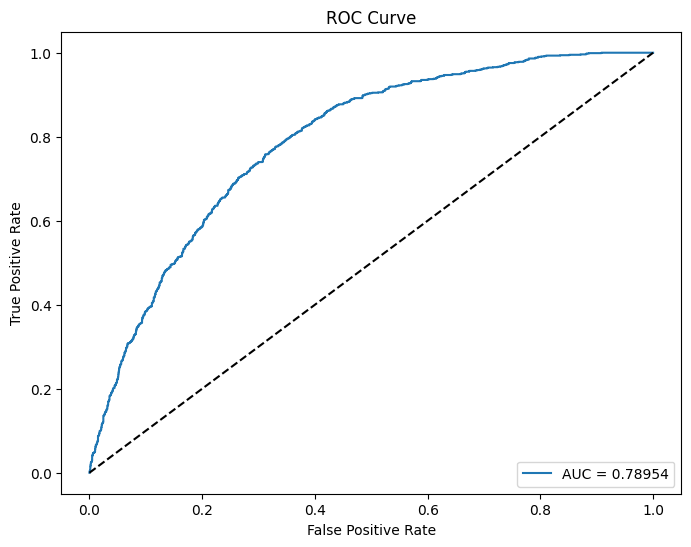

Best parameters found:  {'border_count': 128, 'depth': 3, 'iterations': 500, 'l2_leaf_reg': 5, 'learning_rate': 0.01}


In [219]:
#'scale_pos_weight': 1, 'random_strength': 1.0, 'learning_rate': 0.01, 'l2_leaf_reg': 5, 'iterations': 500, 'depth': 3, 'border_count': 128, 'bagging_temperature': 0.0}
# Initialize CatBoostClassifier
catboost_model = CatBoostClassifier(verbose=0, random_state=42, cat_features=df.select_dtypes(include=['object', 'category']).columns.tolist())

# Define the hyperparameter grid
param_grid = {
    'iterations': [100, 200, 300],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5, 7],
    'border_count': [32, 64, 128]
}

# Set up GridSearchCV
# grid_search = GridSearchCV(estimator=catboost_model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV
# grid_search.fit(X_train, Y_train)

# Get the best model from grid search
# best_catboost_model = grid_search.best_estimator_

# Manually set the best parameters
best_params = {'border_count': 128, 'depth': 3, 'iterations': 500, 'l2_leaf_reg': 5, 'learning_rate': 0.01}
best_catboost_model = CatBoostClassifier(verbose=0, random_state=42, cat_features=df.select_dtypes(include=['object', 'category']).columns.tolist(), **best_params)

# Train the model with the best parameters
best_catboost_model.fit(X_train, Y_train)

# Evaluate the best model using the provided evaluate_model function
evaluate_model(best_catboost_model, X_train, X_test, Y_train, Y_test)

# Output best parameters
print("Best parameters found: ",best_params)

## External Data Test

In [220]:
# Predict probabilities on df_scaled_11_12
pred_prob = LR_model.predict_proba(df_scaled_11_12)[:, 1]

# Predict classes on df_scaled_11_12
pred_class = LR_model.predict(df_scaled_11_12)

# Calculate accuracy
accuracy = accuracy_score(target_11_12, pred_class)

# Calculate AUC score
auc_score = roc_auc_score(target_11_12, pred_prob)

# Create a DataFrame with prediction probability, actual result, and predicted result
results_df = pd.DataFrame({
    'Prediction Probability': pred_prob,
    'Actual Result': target_11_12,
    'Predicted Result': pred_class
})

# Output the results
print("Accuracy: ", accuracy)
print("AUC Score: ", auc_score)
print("Results DataFrame:")
print(results_df.to_string())

Accuracy:  0.7323910482921083
AUC Score:  0.7680956205600621
Results DataFrame:
      Prediction Probability  Actual Result  Predicted Result
0                   0.063300            0.0               0.0
1                   0.058284            0.0               0.0
2                   0.290574            0.0               0.0
3                   0.789160            0.0               1.0
4                   0.075307            0.0               0.0
5                   0.749401            0.0               1.0
6                   0.329258            0.0               0.0
7                   0.147119            0.0               0.0
8                   0.069182            0.0               0.0
9                   0.083467            0.0               0.0
10                  0.367727            0.0               0.0
11                  0.164629            0.0               0.0
12                  0.176453            1.0               0.0
13                  0.114557            0.0         